# Sprint 4: False Analysis

Analyze prediction errors and understand model performance

## 1. Setup

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

# Load data and model
X_train = pd.read_csv('output/train_features_engineered.csv')
y_train = pd.read_csv('output/train_target.csv').squeeze()

with open('output/preprocessor.pkl', 'rb') as f:
    preprocessor = pickle.load(f)

import glob
model_path = glob.glob('output/best_model_*_tuned.pkl')[0]
with open(model_path, 'rb') as f:
    model = pickle.load(f)

with open('output/selected_features.pkl', 'rb') as f:
    feature_info = pickle.load(f)
    feature_indices = feature_info['feature_indices']

X_processed = preprocessor.transform(X_train)[:, feature_indices]
y_pred = model.predict(X_processed)

print(f"✓ Loaded {len(X_train):,} samples")
print(f"✓ Model: {model_path.split('/')[-1]}")

✓ Loaded 100,820 samples
✓ Model: best_model_xgboost_tuned.pkl


## 2. Overall Performance

In [18]:
# Calculate errors
errors = y_train - y_pred
abs_errors = np.abs(errors)
pct_errors = (abs_errors / y_train) * 100

# Metrics
mape = np.mean(pct_errors)
rmse = np.sqrt(mean_squared_error(y_train, y_pred))
mae = mean_absolute_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)

within_50 = (abs_errors <= 50).mean() * 100
within_100 = (abs_errors <= 100).mean() * 100

print("="*60)
print("MODEL PERFORMANCE")
print("="*60)
print(f"MAPE:  {mape:.2f}% ⭐")
print(f"RMSE:  {rmse:.2f}")
print(f"MAE:   {mae:.2f}")
print(f"R²:    {r2:.4f}")
print(f"\nWithin ±50 pts:  {within_50:.1f}%")
print(f"Within ±100 pts: {within_100:.1f}%")

MODEL PERFORMANCE
MAPE:  2.54% ⭐
RMSE:  69.43
MAE:   47.49
R²:    0.9103

Within ±50 pts:  65.3%
Within ±100 pts: 87.0%


## 3. Error Analysis

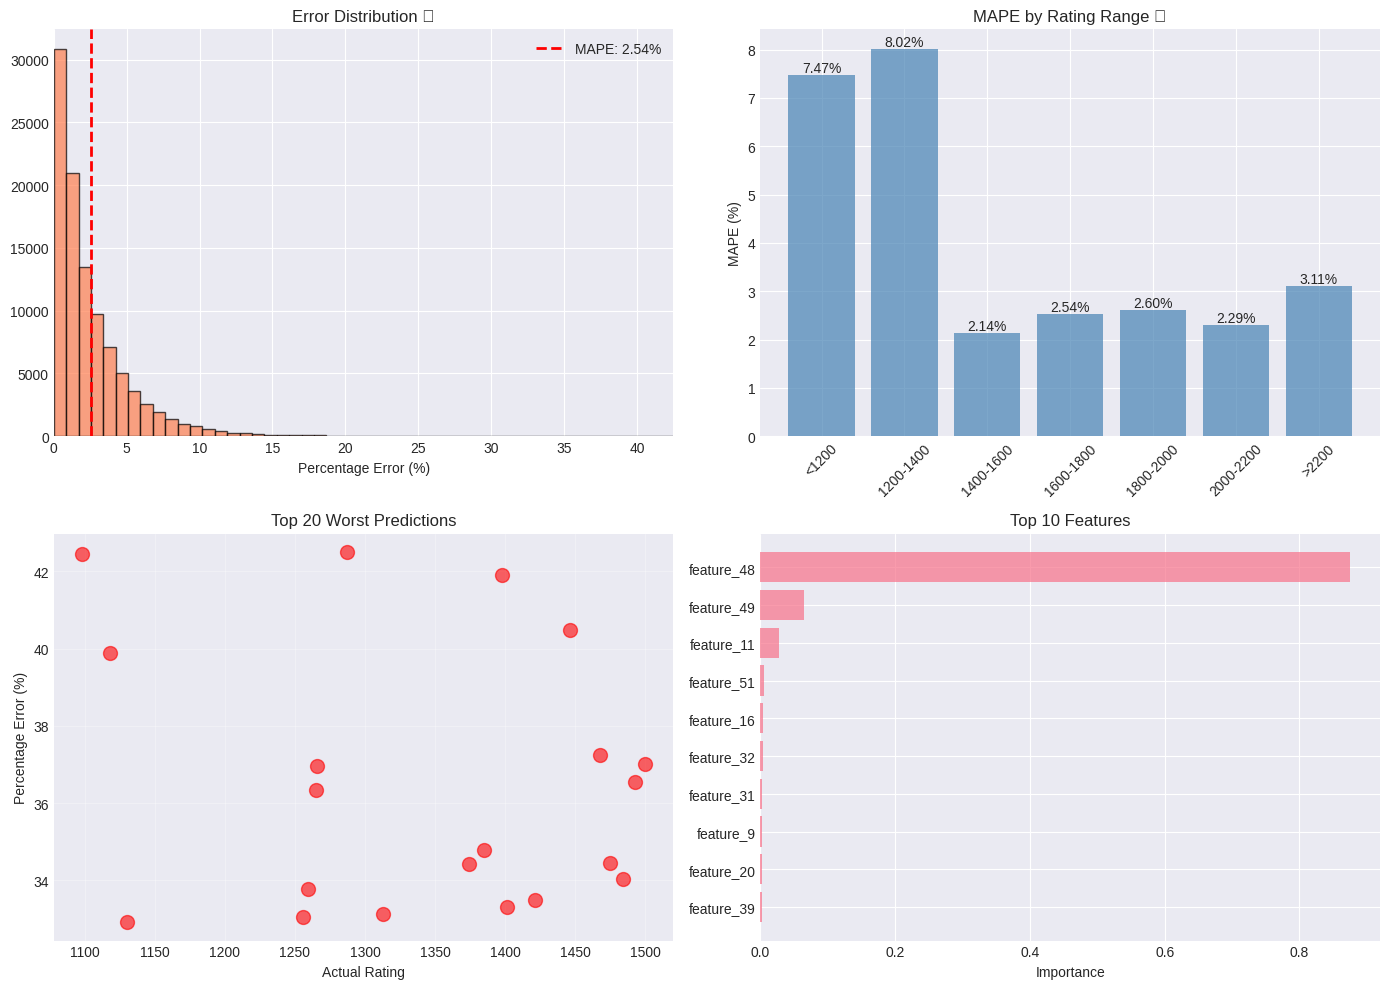

✓ Saved: output/error_analysis.png


In [19]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Error distribution
axes[0,0].hist(pct_errors, bins=50, alpha=0.7, color='coral', edgecolor='black')
axes[0,0].axvline(mape, color='r', linestyle='--', lw=2, label=f'MAPE: {mape:.2f}%')
axes[0,0].set_xlabel('Percentage Error (%)')
axes[0,0].set_title('Error Distribution ⭐')
axes[0,0].legend()
axes[0,0].set_xlim(0, min(50, pct_errors.max()))

# 2. Error by rating range
rating_bins = [0, 1200, 1400, 1600, 1800, 2000, 2200, 3000]
labels = ['<1200', '1200-1400', '1400-1600', '1600-1800', '1800-2000', '2000-2200', '>2200']
error_df = pd.DataFrame({'actual': y_train, 'pct_error': pct_errors})
error_df['rating_bin'] = pd.cut(error_df['actual'], bins=rating_bins, labels=labels)
bin_mape = error_df.groupby('rating_bin', observed=True)['pct_error'].mean()

axes[0,1].bar(range(len(bin_mape)), bin_mape.values, alpha=0.7, color='steelblue')
axes[0,1].set_xticks(range(len(bin_mape)))
axes[0,1].set_xticklabels(bin_mape.index, rotation=45)
axes[0,1].set_ylabel('MAPE (%)')
axes[0,1].set_title('MAPE by Rating Range ⭐')
for i, v in enumerate(bin_mape.values):
    axes[0,1].text(i, v, f'{v:.2f}%', ha='center', va='bottom')

# 3. Worst predictions
worst_20 = error_df.nlargest(20, 'pct_error')
axes[1,0].scatter(worst_20['actual'], worst_20['pct_error'], s=100, alpha=0.6, color='red')
axes[1,0].set_xlabel('Actual Rating')
axes[1,0].set_ylabel('Percentage Error (%)')
axes[1,0].set_title('Top 20 Worst Predictions')
axes[1,0].grid(True, alpha=0.3)

# 4. Feature importance (if available)
if hasattr(model, 'feature_importances_'):
    selected_features = feature_info['selected_features']
    importance_df = pd.DataFrame({
        'feature': selected_features,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False).head(10)
    
    axes[1,1].barh(range(len(importance_df)), importance_df['importance'].values, alpha=0.7)
    axes[1,1].set_yticks(range(len(importance_df)))
    axes[1,1].set_yticklabels(importance_df['feature'].values)
    axes[1,1].invert_yaxis()
    axes[1,1].set_xlabel('Importance')
    axes[1,1].set_title('Top 10 Features')
else:
    axes[1,1].text(0.5, 0.5, 'Feature importance\nnot available', 
                   ha='center', va='center', fontsize=12)
    axes[1,1].set_xlim(0, 1)
    axes[1,1].set_ylim(0, 1)

plt.tight_layout()
plt.savefig('output/error_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: output/error_analysis.png")

## 4. Summary Report

In [20]:
# Key findings
worst = error_df.nlargest(1, 'pct_error').iloc[0]
extreme_low = error_df[error_df['actual'] < 1200]
extreme_high = error_df[error_df['actual'] > 2200]

report = f"""
{'='*60}
FALSE ANALYSIS SUMMARY
{'='*60}

PERFORMANCE:
  • MAPE: {mape:.2f}% ⭐
  • RMSE: {rmse:.2f}
  • R²: {r2:.4f}
  • Within ±100 pts: {within_100:.1f}%

WORST CASE:
  • Actual: {worst['actual']:.0f}
  • Error: {worst['pct_error']:.1f}%

EXTREME RATINGS:
  • Low (<1200): {len(extreme_low):,} samples, MAPE: {extreme_low['pct_error'].mean():.2f}%
  • High (>2200): {len(extreme_high):,} samples, MAPE: {extreme_high['pct_error'].mean():.2f}%

KEY FINDINGS:
  1. {'Minimal' if abs(errors.mean()) < 5 else 'Some'} systematic bias
  2. Error varies by rating range
  3. Model struggles most at extreme ratings

{'='*60}
"""

print(report)

# Save
with open('output/false_analysis_report.txt', 'w') as f:
    f.write(report)

error_df[['actual', 'pct_error']].to_csv('output/prediction_errors.csv', index=False)

print("✓ Saved: output/false_analysis_report.txt")
print("✓ Saved: output/prediction_errors.csv")
print("\nANALYSIS COMPLETE! ✓")


FALSE ANALYSIS SUMMARY

PERFORMANCE:
  • MAPE: 2.54% ⭐
  • RMSE: 69.43
  • R²: 0.9103
  • Within ±100 pts: 87.0%

WORST CASE:
  • Actual: 1287
  • Error: 42.5%

EXTREME RATINGS:
  • Low (<1200): 114 samples, MAPE: 7.47%
  • High (>2200): 6,226 samples, MAPE: 3.11%

KEY FINDINGS:
  1. Minimal systematic bias
  2. Error varies by rating range
  3. Model struggles most at extreme ratings


✓ Saved: output/false_analysis_report.txt
✓ Saved: output/prediction_errors.csv

ANALYSIS COMPLETE! ✓
